# LE-3DliteとQR001の動作確認
3つのLE-3Dliteを同じ場所に置き，コヒーレンスを計算．

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from obspy import UTCDateTime
import readwin
from scipy import signal, fftpack
import matplotlib
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['lines.linewidth'] = 1

In [19]:
datadir1 = './data/QR001/PQR0121A0009/202307/13/16/' 
datadir2 = './data/QR001/PQR0121A0008/202307/13/16/' 
datadir3 = './data/QR001/PQR0121A0010/202307/13/16/' 

date1 = UTCDateTime('2023-07-13T16:40:00')
date2 = UTCDateTime('2023-07-13T16:41:00')

In [20]:
# ディレクトリ内の全てのwinファイルを読み込む
st1 = readwin.read_win(datadir1 + '*')
st2 = readwin.read_win(datadir2 + '*')
st3 = readwin.read_win(datadir3 + '*')

# 使用する範囲のデータを切り出す
st1.trim(date1, date2)
st2.trim(date1, date2)
st3.trim(date1, date2)

# Streamオブジェクトの中から情報を取り出す
stats = st1.select(channel='f100')[0].stats
dt = stats.delta    # サンプリング間隔
npts = stats.npts   # サンプル数（データの個数）
t = np.arange(stats.npts)*stats.delta   # 時間軸の作成


In [21]:
def smoothing(data, nhan):
    w = np.array([0.25, 0.5, 0.25])
    for i in range(nhan):
        data[:] = np.convolve(data[:], w, mode='same')
def fourier(data):
    nt = len(data)
    data = data - np.mean(data)
    taper = signal.windows.tukey(nt, alpha=0.05)
    fastlen = fftpack.next_fast_len(nt)
    data_time = np.zeros(fastlen)
    data_time[:nt] = data*taper
    data_freq = fftpack.fft(data_time)
    freq = fftpack.fftfreq(fastlen, d=dt)
    return data_freq[:fastlen//2], freq[:fastlen//2]

def cal_coherence(data1, data2):
    data1_freq, freq = fourier(data1)
    data2_freq, _ = fourier(data2)
    p12 = np.conj(data1_freq)*data2_freq
    p11 = np.power(np.abs(data1_freq),2)
    p22 = np.power(np.abs(data2_freq),2)
    nhan = 10
    smoothing(p12, nhan)
    smoothing(p11, nhan)
    smoothing(p22, nhan)
    coh = np.abs(p12)/np.sqrt(p11*p22)
    phase = np.arctan2(np.imag(p12), np.real(p12))
    return coh, phase, freq

In [22]:
def plot_coherence(wave1, wave2, wave3, title):
    fig = plt.figure(figsize=(10,5), dpi=300, tight_layout=True)
    ax1 = fig.add_subplot(3,1,1)
    ax1.plot(t, wave1, label='1', color='#2196F3')
    ax1.legend()
    ax2 = fig.add_subplot(3,1,2)
    ax2.plot(t, wave2, label='2', color='#2196F3')
    ax2.legend()
    ax3 = fig.add_subplot(3,1,3)
    ax3.plot(t, wave3, label='3', color='#2196F3')
    ax3.set_xlabel('Time (s)')
    ax3.legend()
    fig.suptitle(title)
    plt.show()
    plt.close()

    fmin = 0.1
    fmax = 100
    coh12, phase12, freq = cal_coherence(wave1, wave2)
    coh23, phase23, _ = cal_coherence(wave2, wave3)
    coh31, phase31, _ = cal_coherence(wave3, wave1)
    fig = plt.figure(figsize=(10,5), dpi=300, tight_layout=True)
    ax1 = fig.add_subplot(2,3,1)
    ax1.plot(freq, coh12, color='#2196F3')
    ax1.set_ylabel('Coherence')
    ax1.set_title('1 - 2')
    ax1.set_xscale('log')
    ax1.set_xlim(fmin, fmax)
    ax2 = fig.add_subplot(2,3,4)
    ax2.plot(freq, phase12*180/np.pi, color='#FF5722')
    ax2.set_xlabel('Frequency (Hz)')
    ax2.set_ylabel('Phase')
    ax2.set_xscale('log')
    ax2.set_xlim(fmin, fmax)
    ax2.set_ylim(-180, 180)
    ax3 = fig.add_subplot(2,3,2)
    ax3.plot(freq, coh23, color='#2196F3')
    ax3.set_title('2 - 3')
    ax3.set_xscale('log')
    ax3.set_xlim(fmin, fmax)
    ax4 = fig.add_subplot(2,3,5)
    ax4.plot(freq, phase23*180/np.pi, color='#FF5722')
    ax4.set_xlabel('Frequency (Hz)')
    ax4.set_xscale('log')
    ax4.set_xlim(fmin, fmax)
    ax4.set_ylim(-180, 180)
    ax5 = fig.add_subplot(2,3,3)
    ax5.plot(freq, coh31, color='#2196F3')
    ax5.set_title('3 - 1')
    ax5.set_xscale('log')
    ax5.set_xlim(fmin, fmax)
    ax6 = fig.add_subplot(2,3,6)
    ax6.plot(freq, phase31*180/np.pi, color='#FF5722')
    ax6.set_xlabel('Frequency (Hz)')
    ax6.set_xscale('log')
    ax6.set_xlim(fmin, fmax)
    ax6.set_ylim(-180, 180)
    fig.suptitle(title)
    plt.show()
    plt.close()

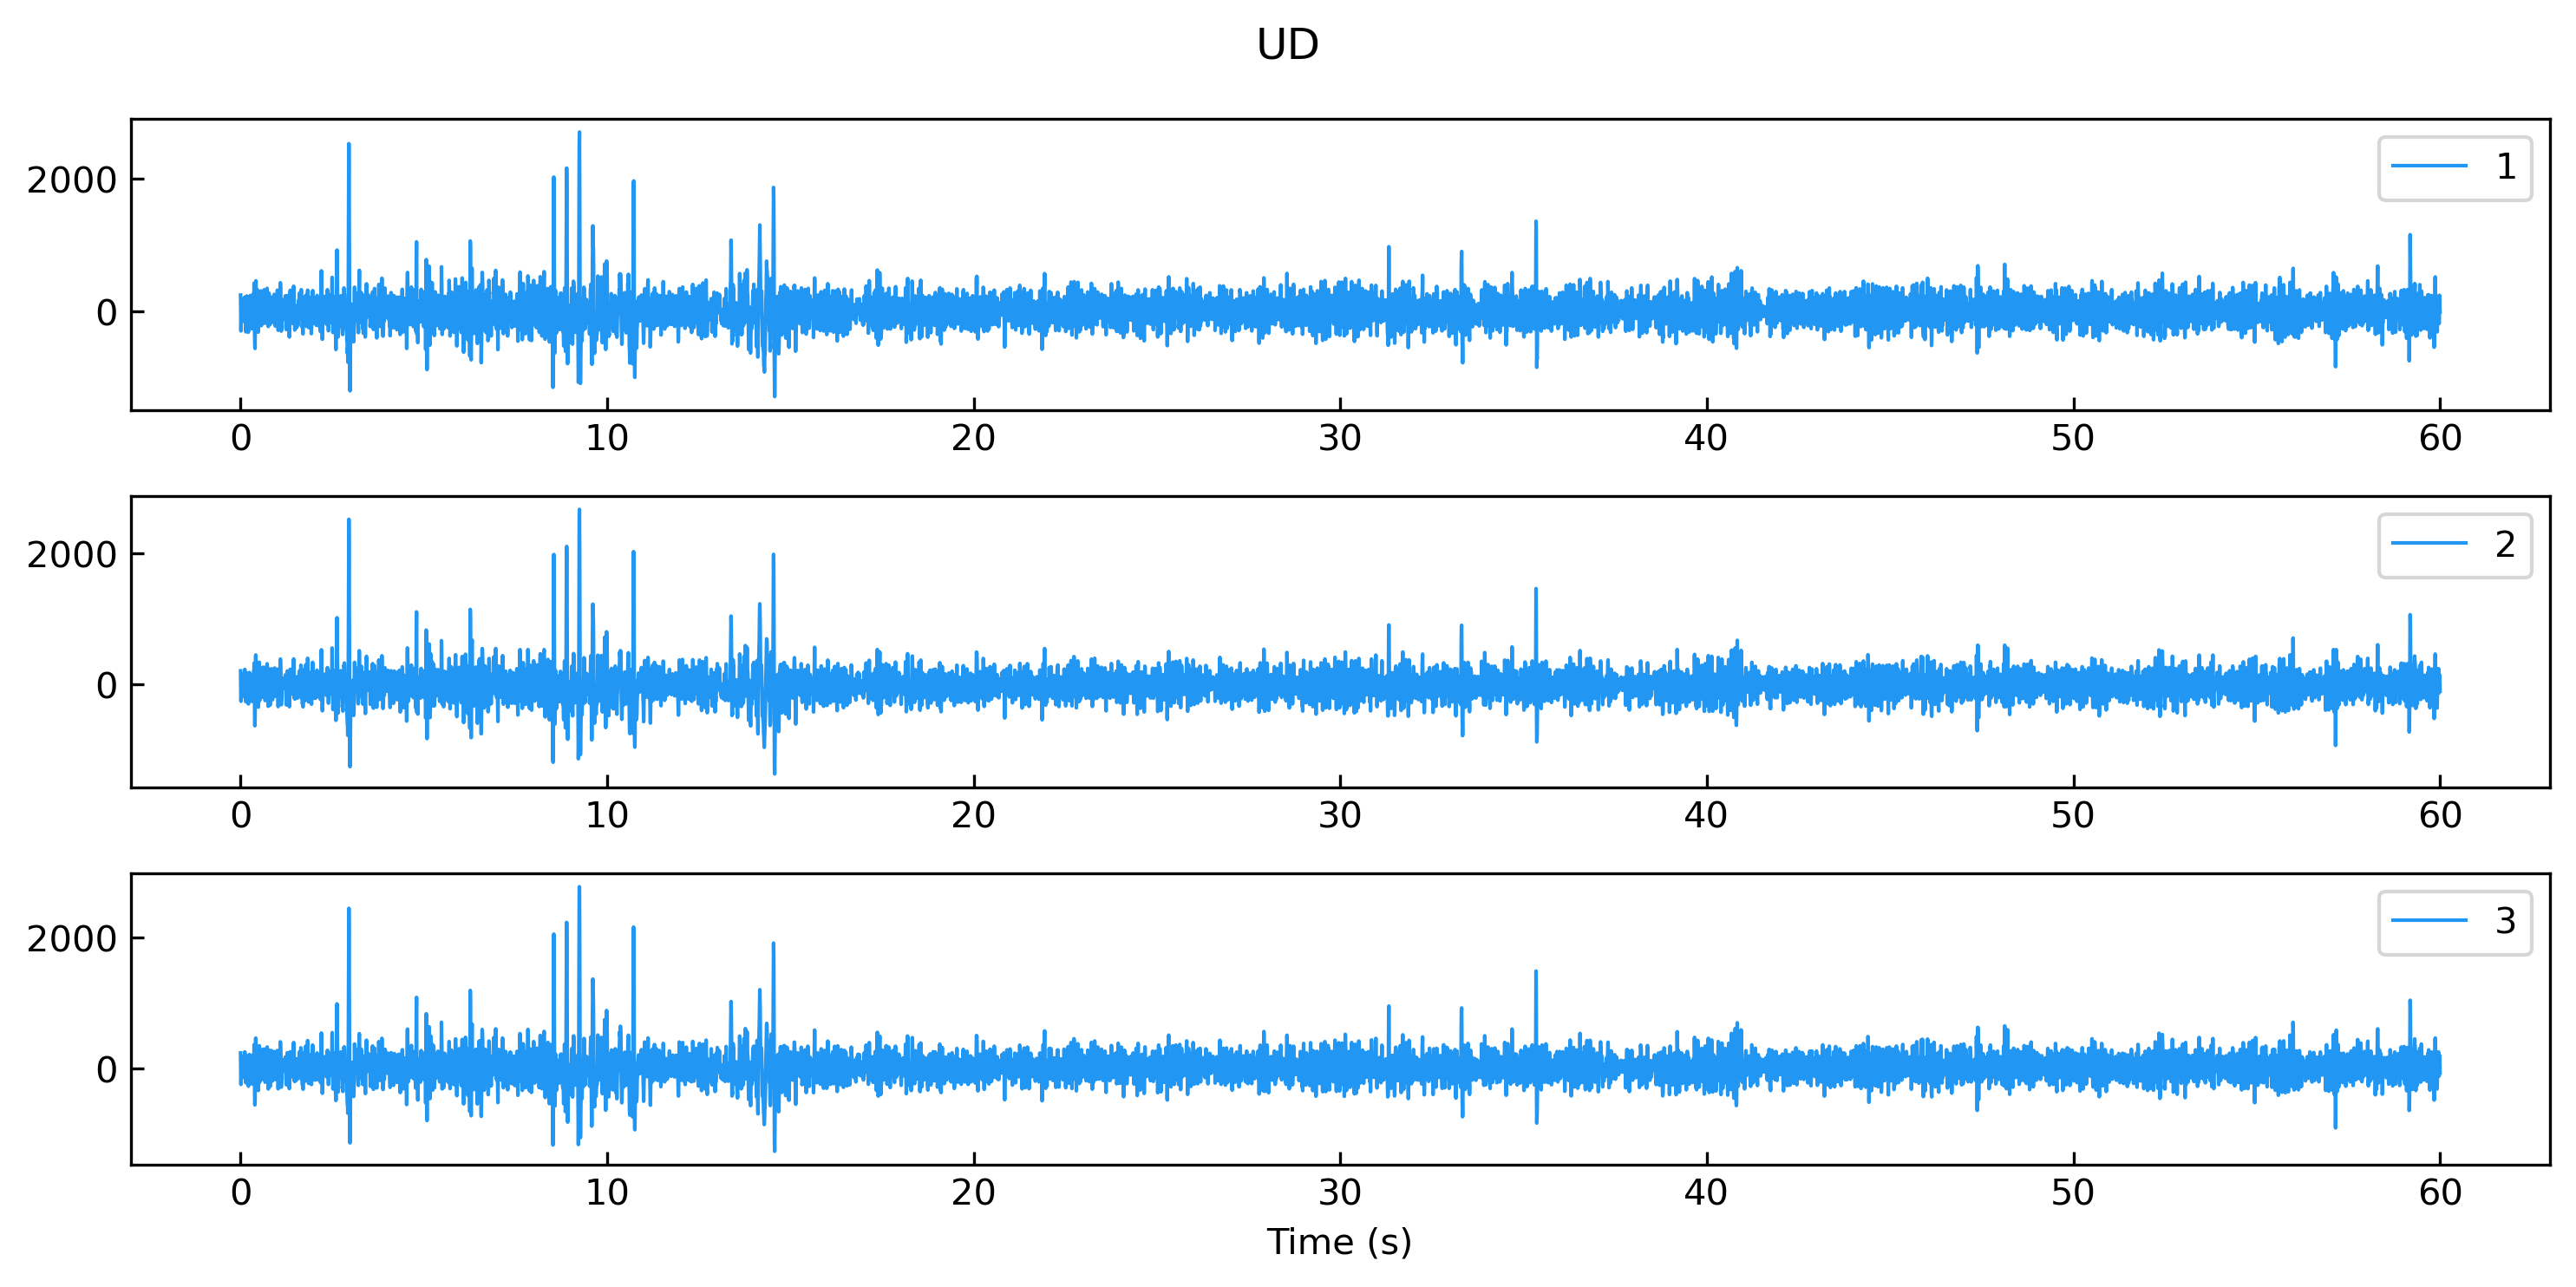

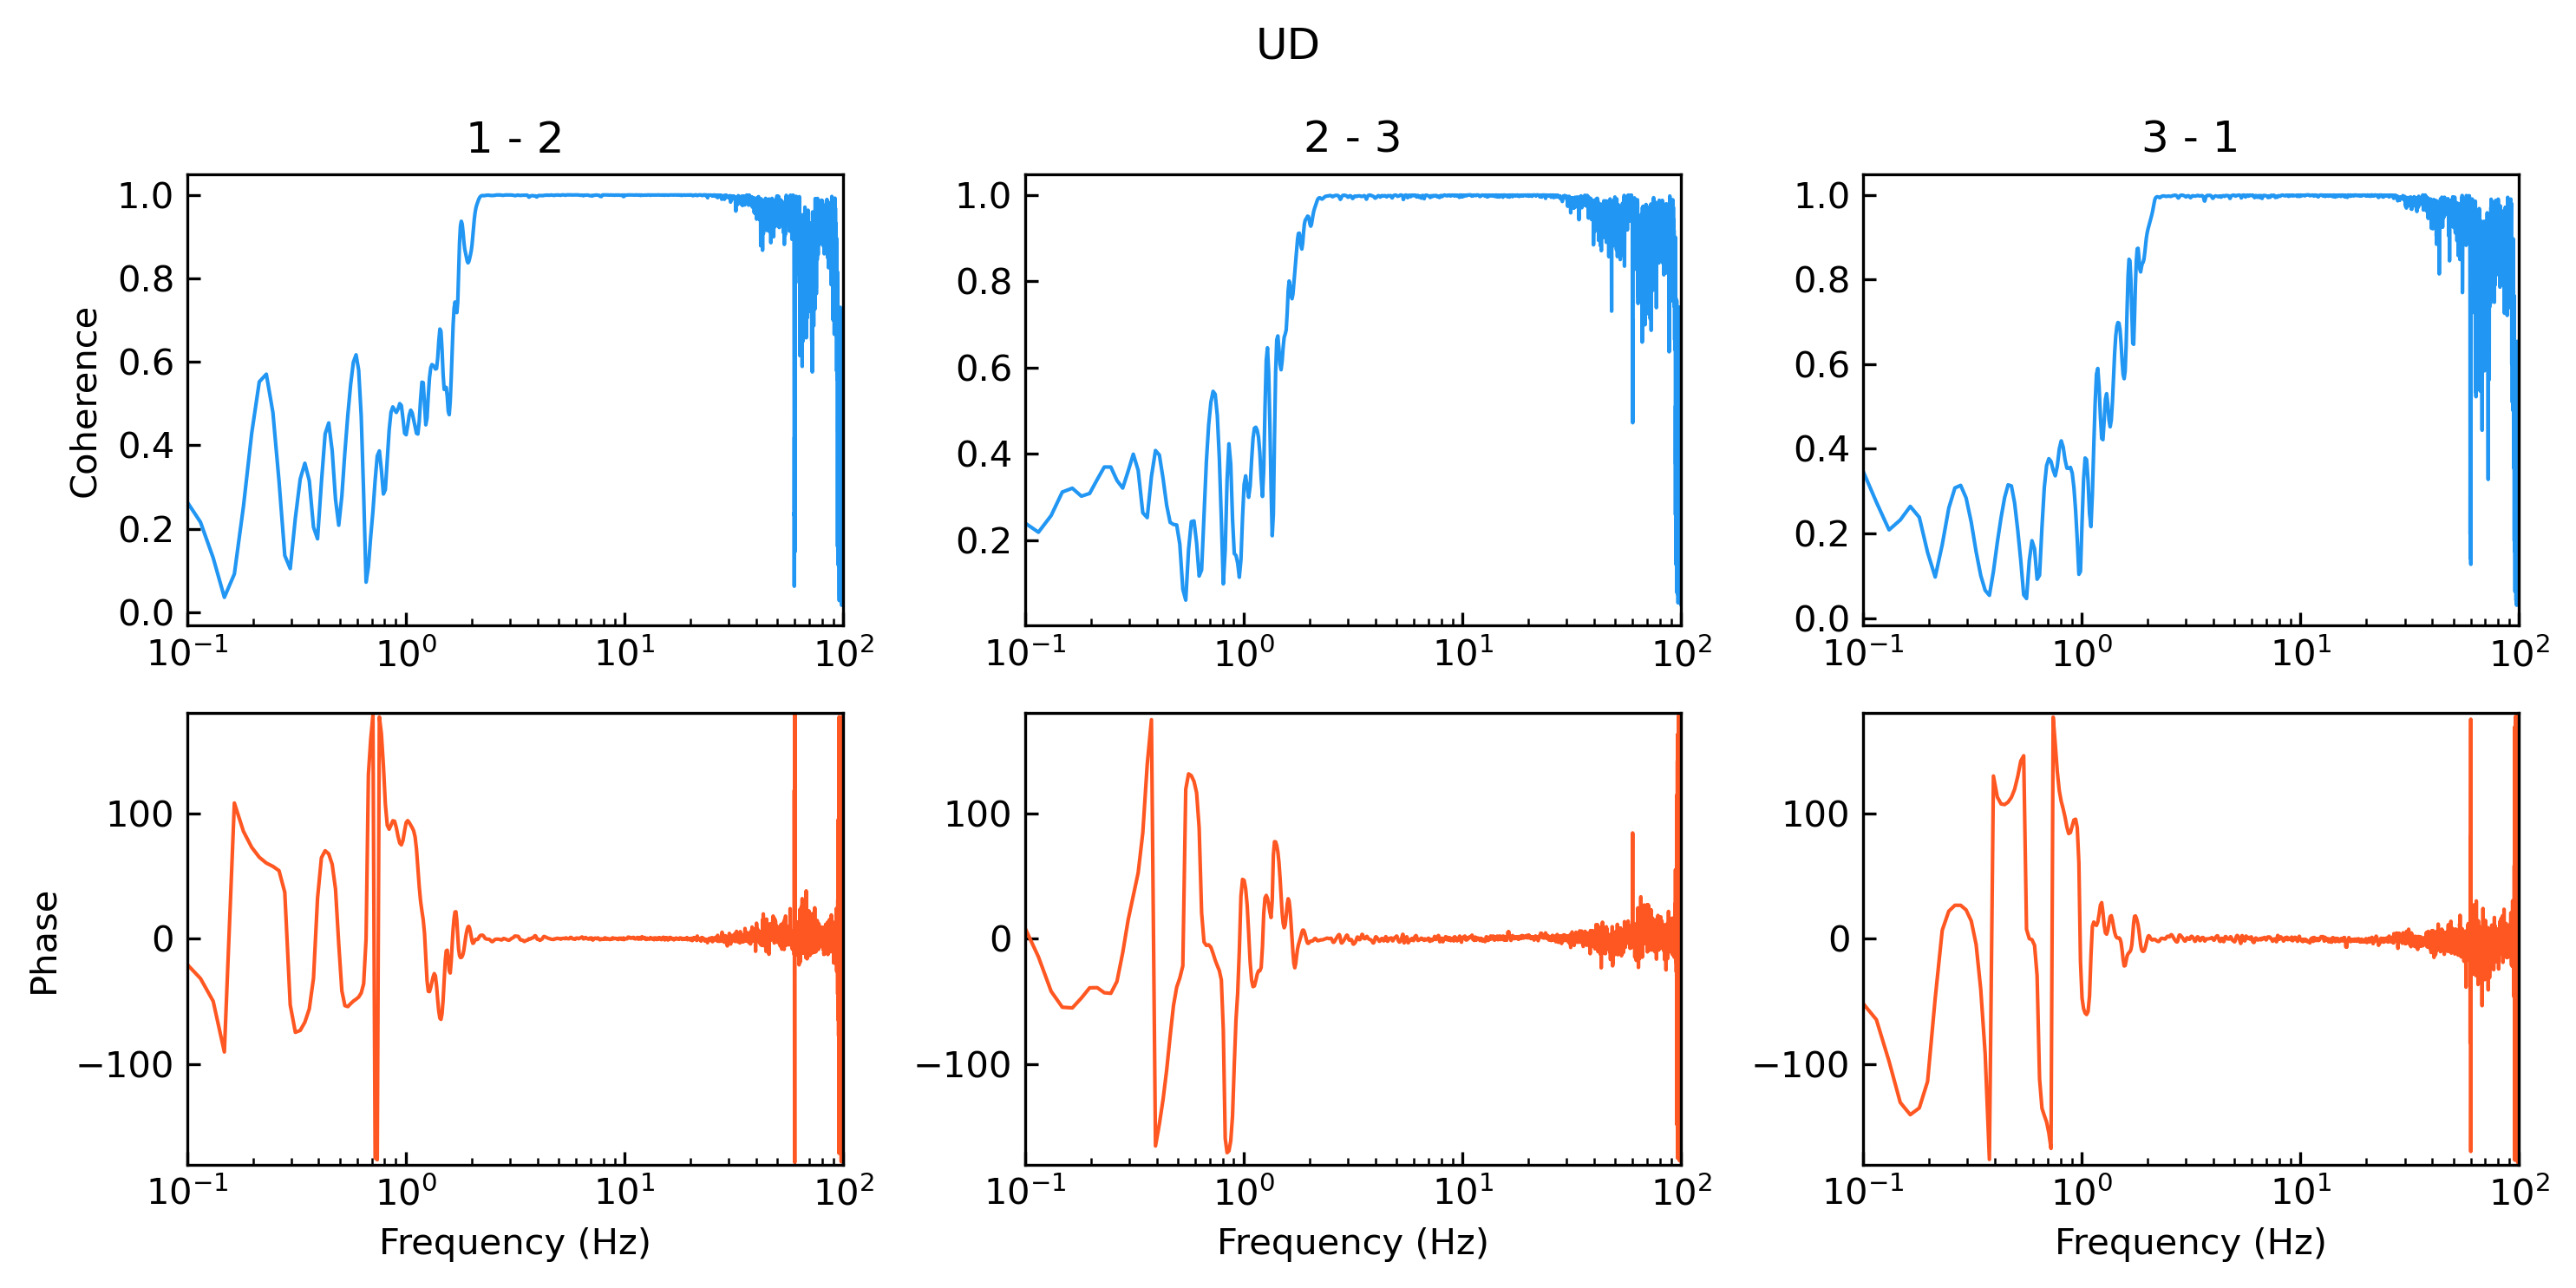

In [23]:
# ud components
ch = 'f100'
wave1 = st1.select(channel=ch)[0].data
wave2 = st2.select(channel=ch)[0].data
wave3 = st3.select(channel=ch)[0].data
plot_coherence(wave1, wave2, wave3, 'UD')

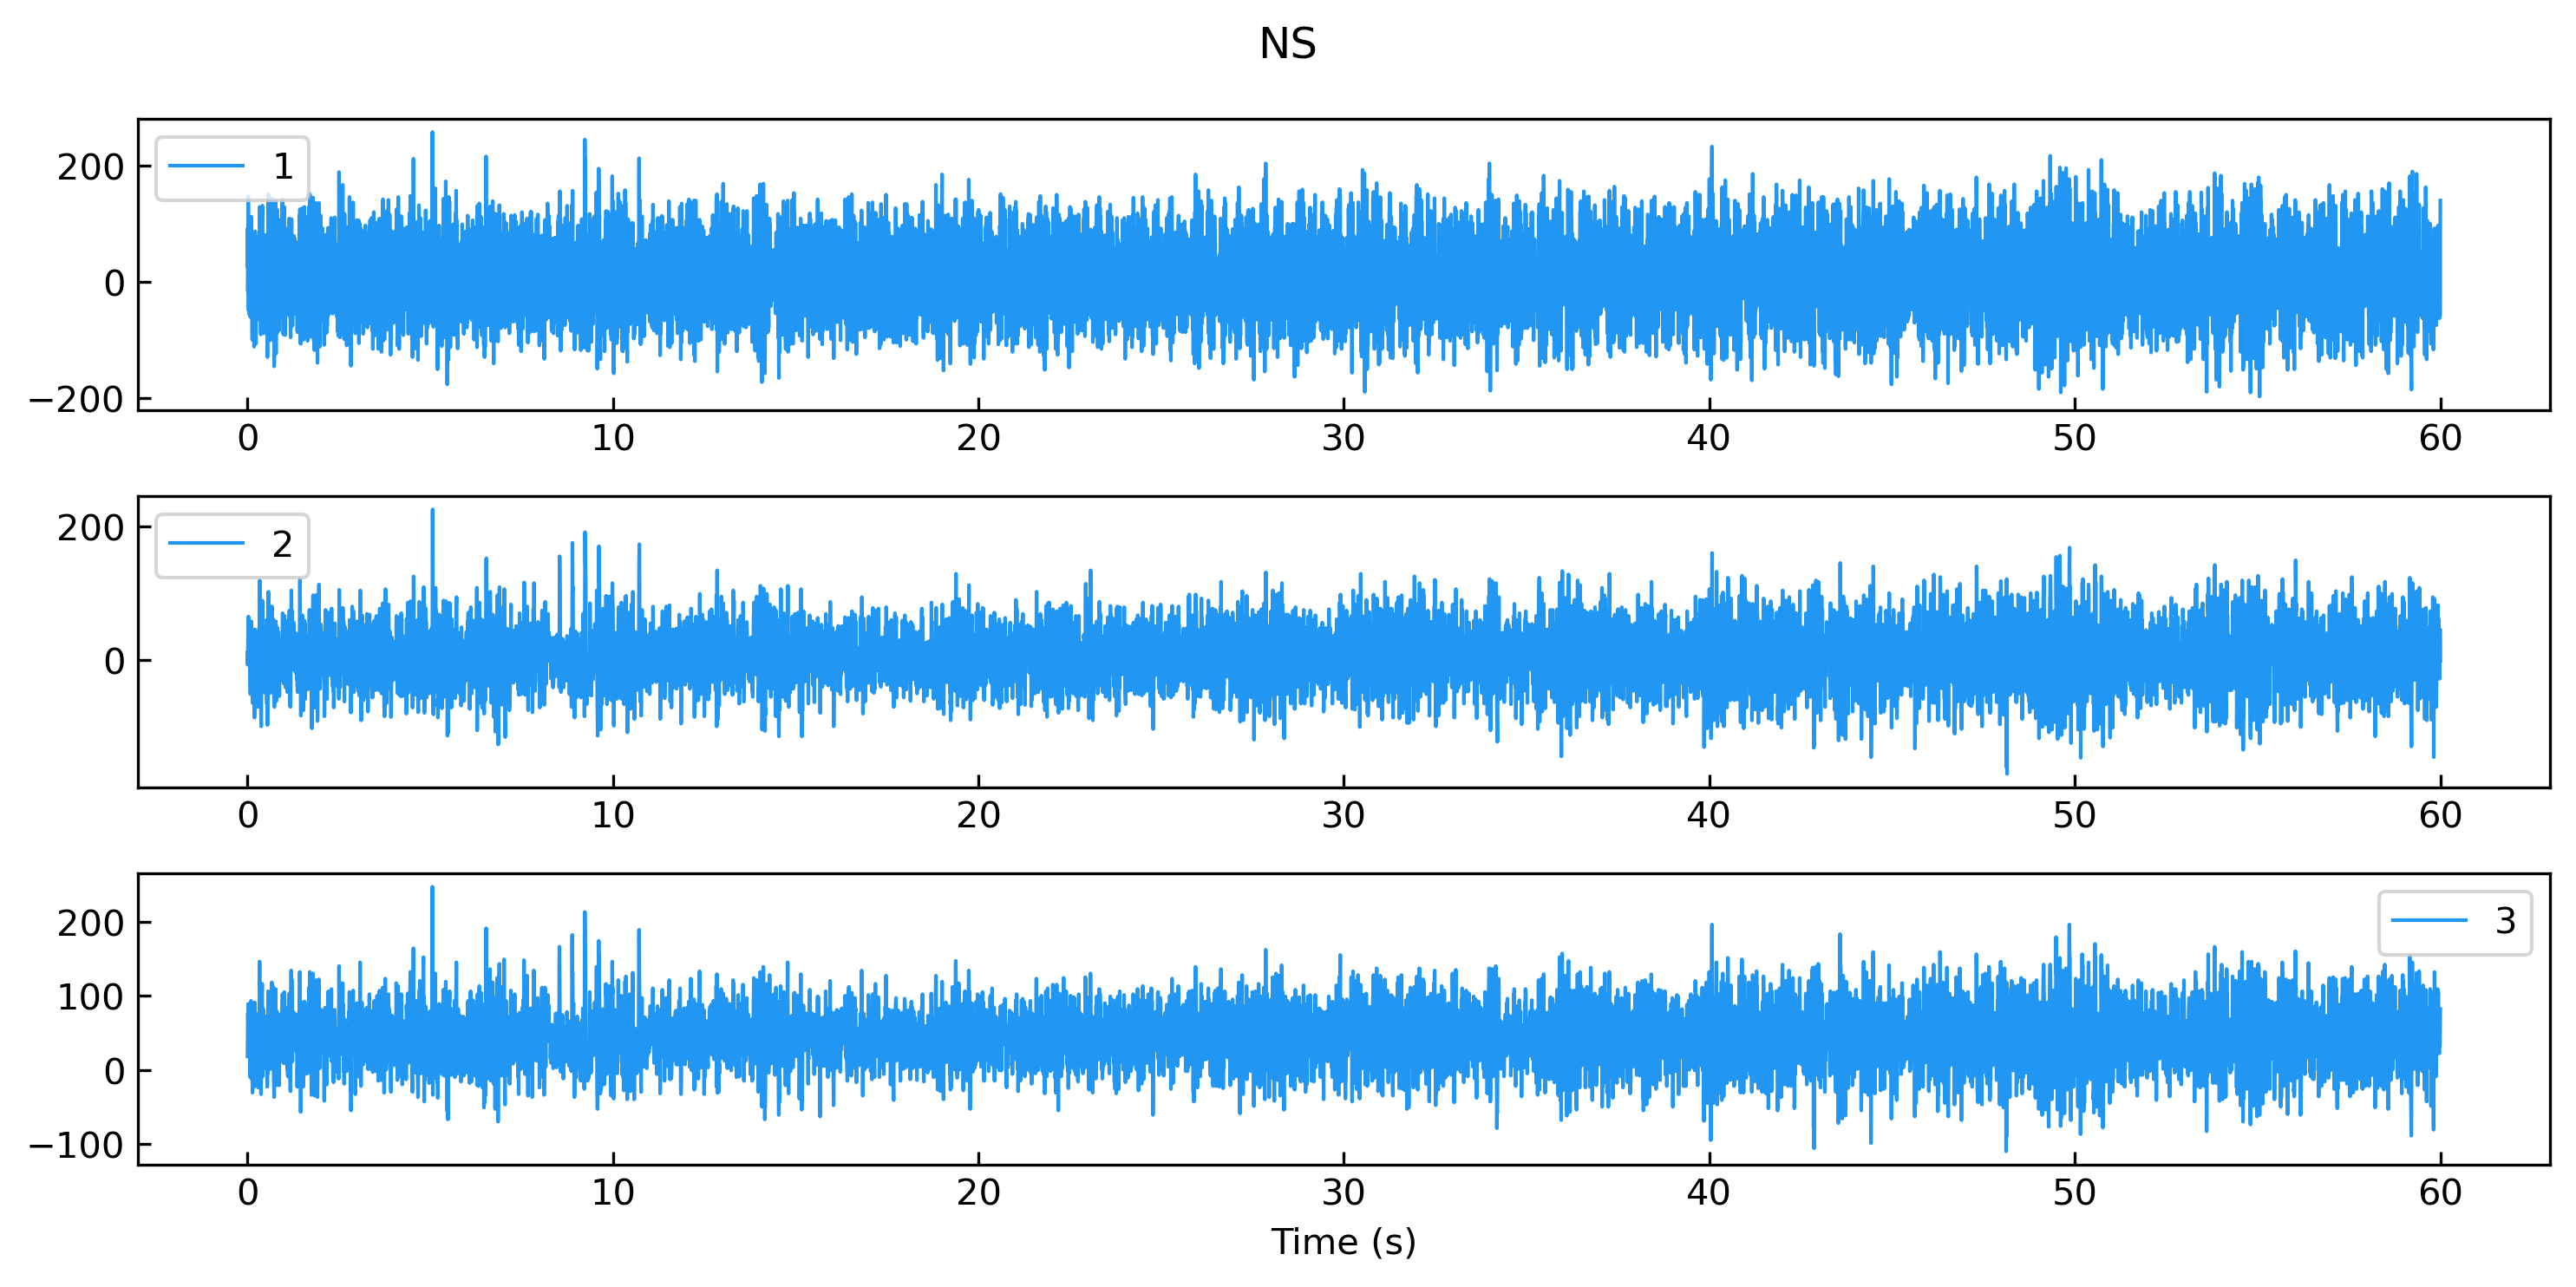

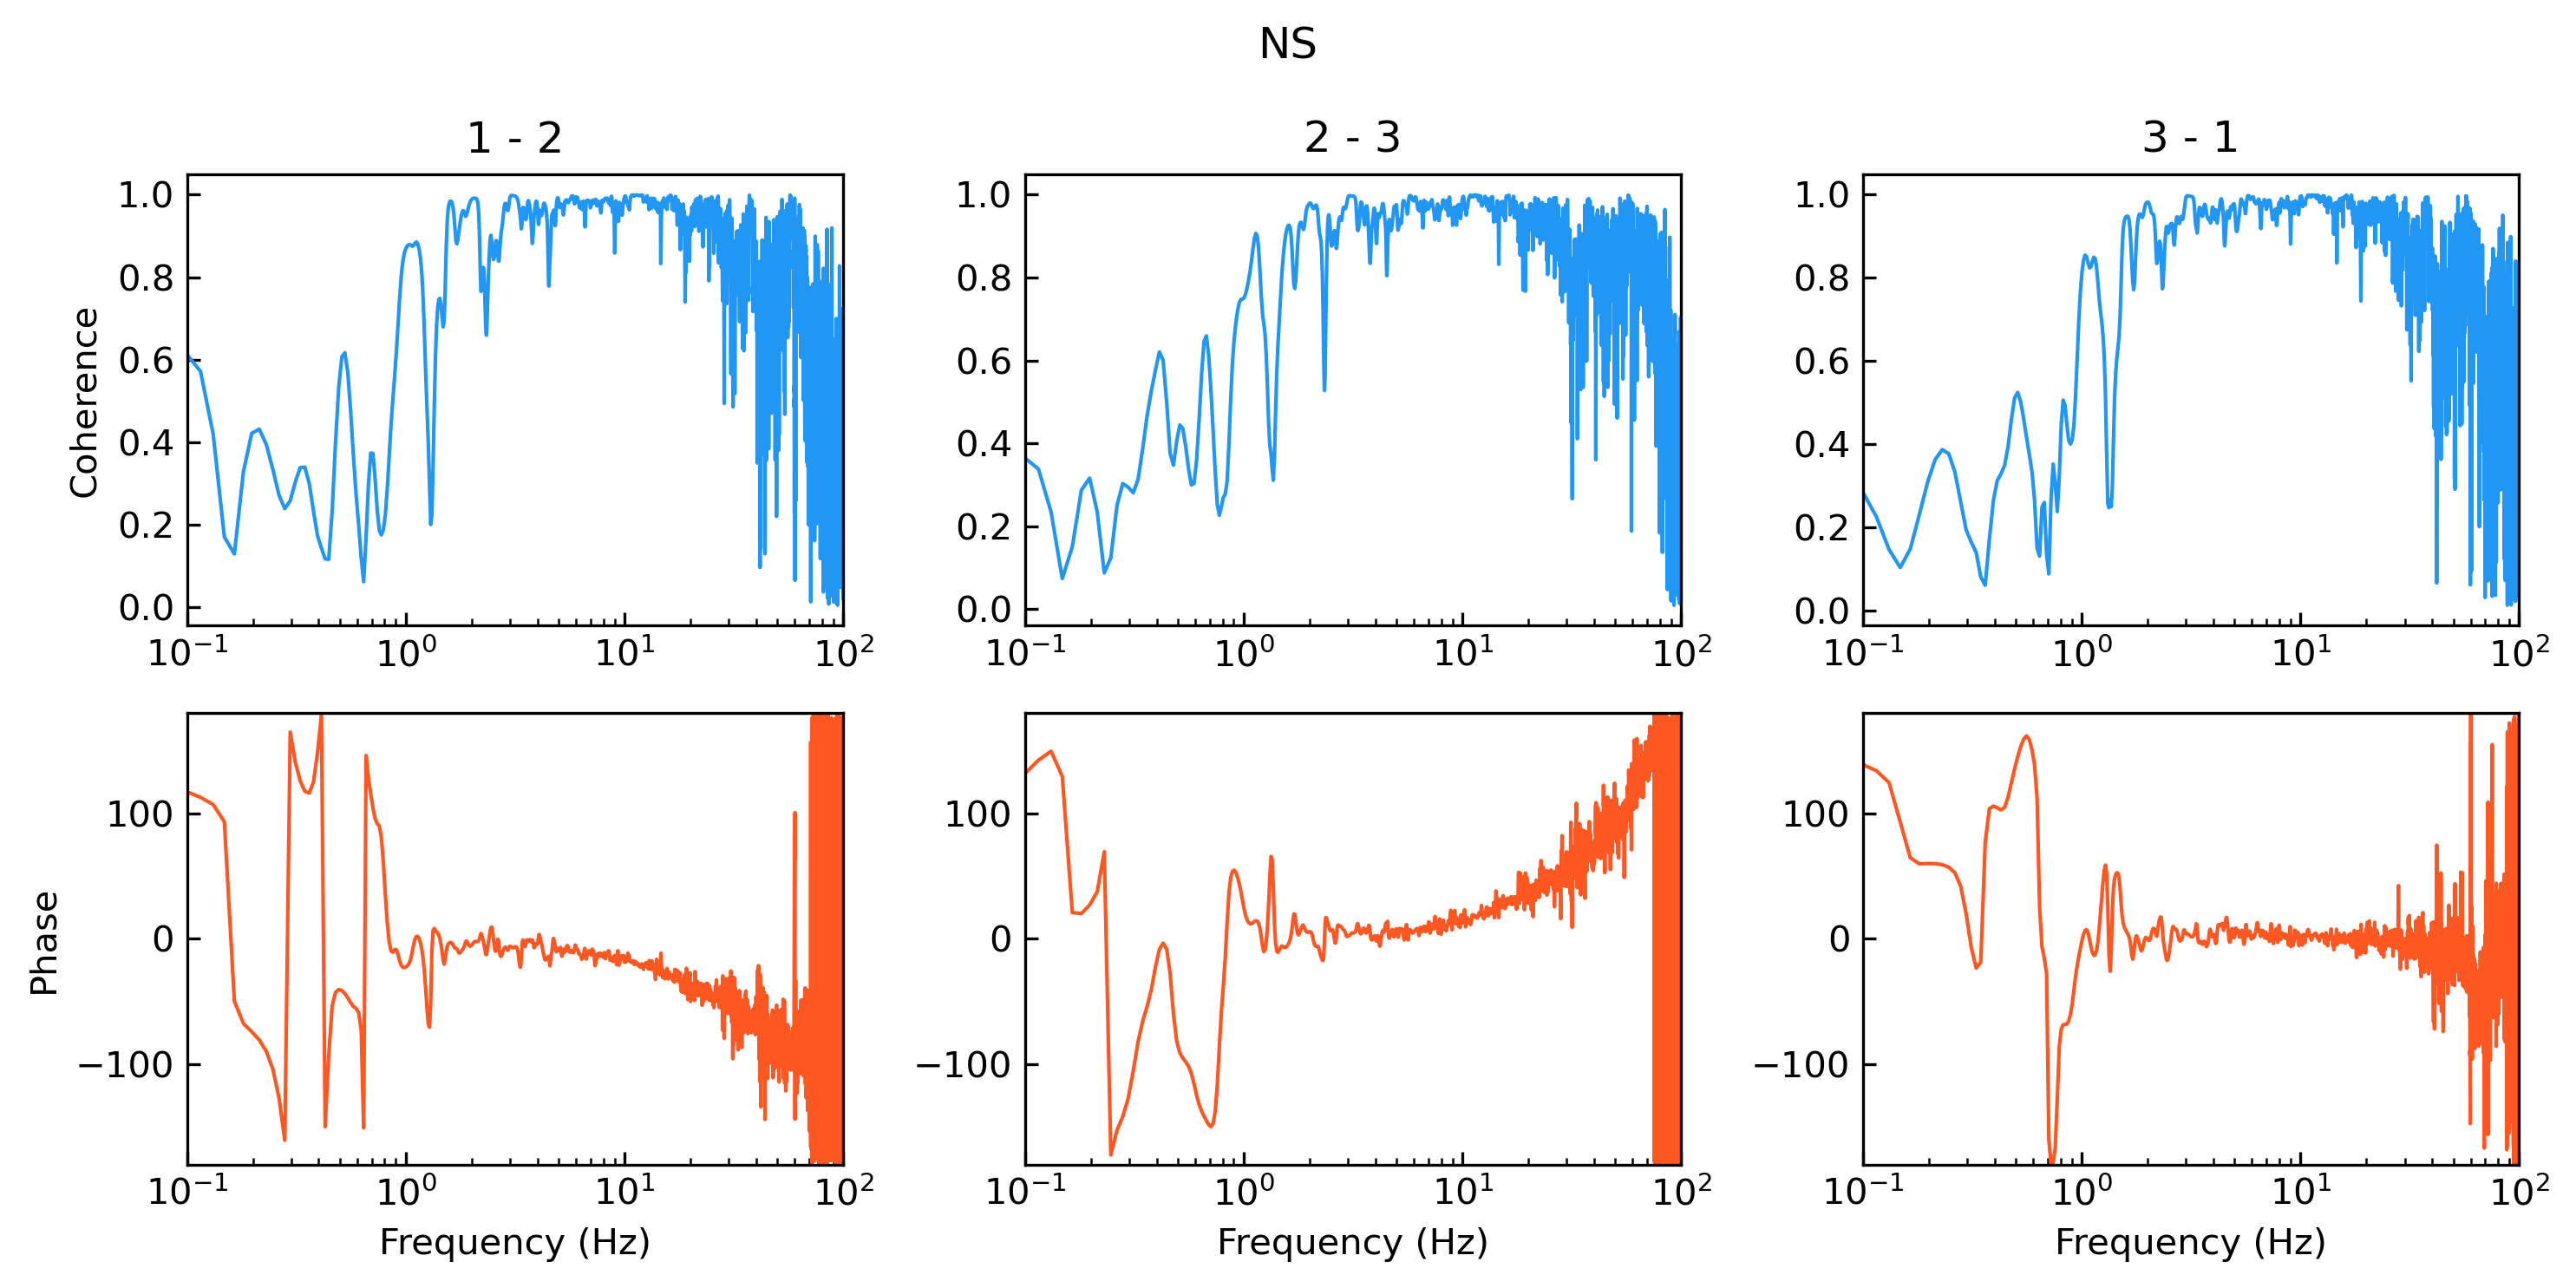

In [24]:
# ns components
ch = 'f101'
wave1 = st1.select(channel=ch)[0].data
wave2 = st2.select(channel=ch)[0].data
wave3 = st3.select(channel=ch)[0].data
plot_coherence(wave1, wave2, wave3, 'NS')

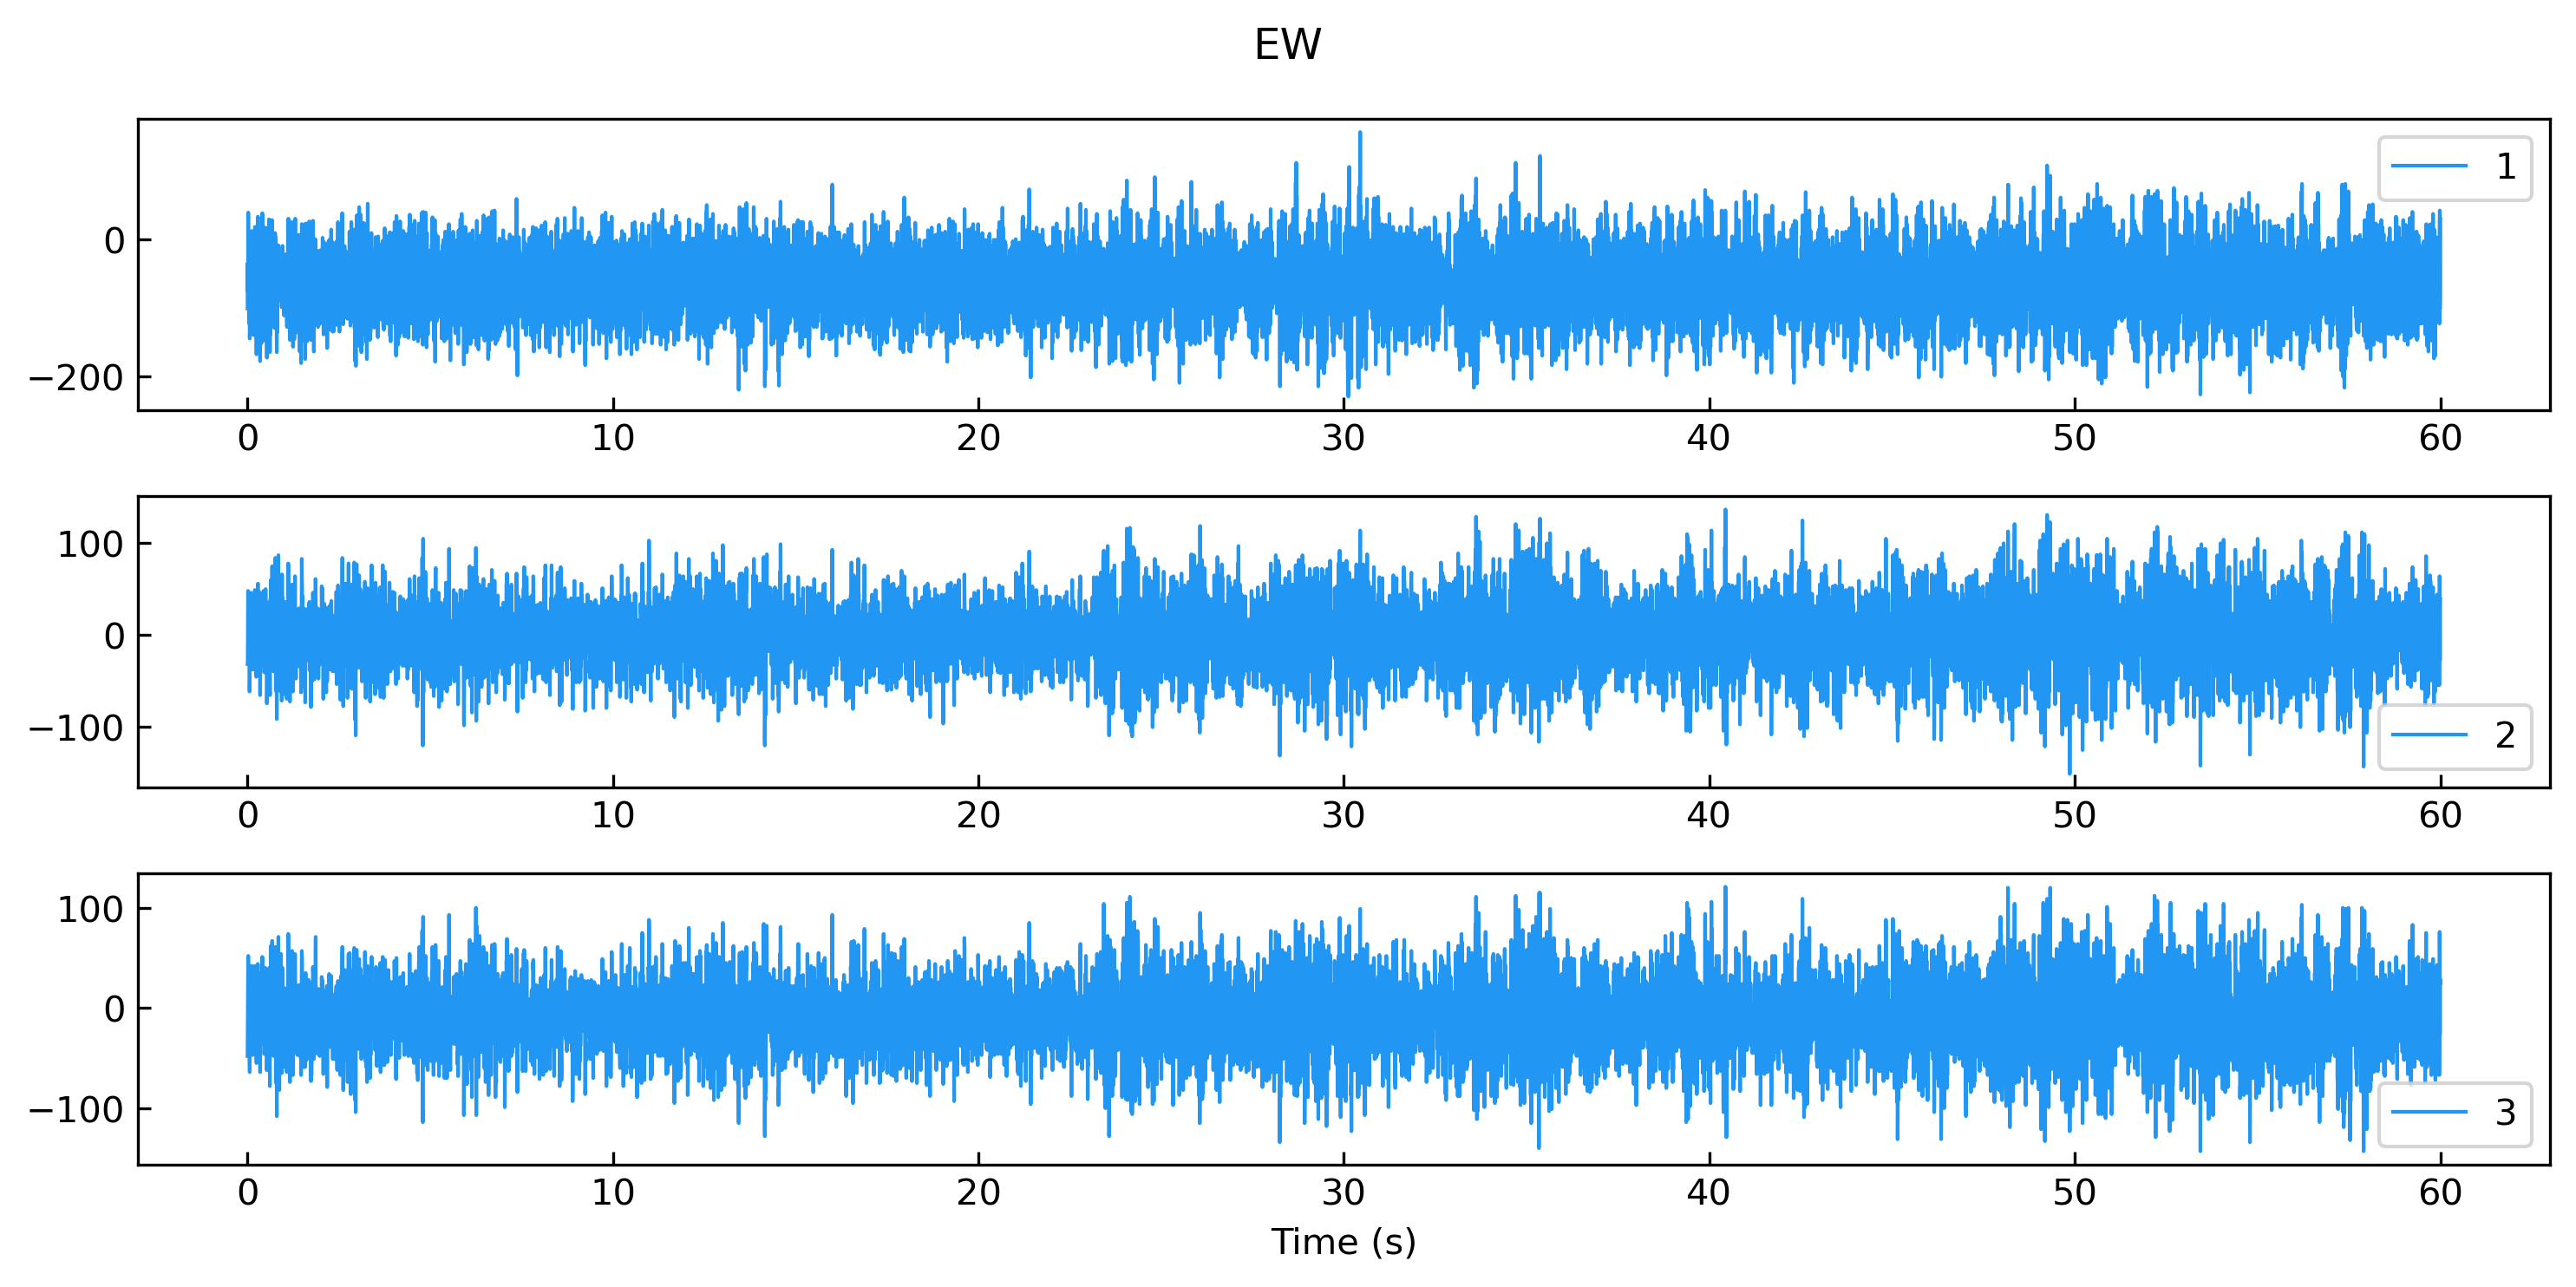

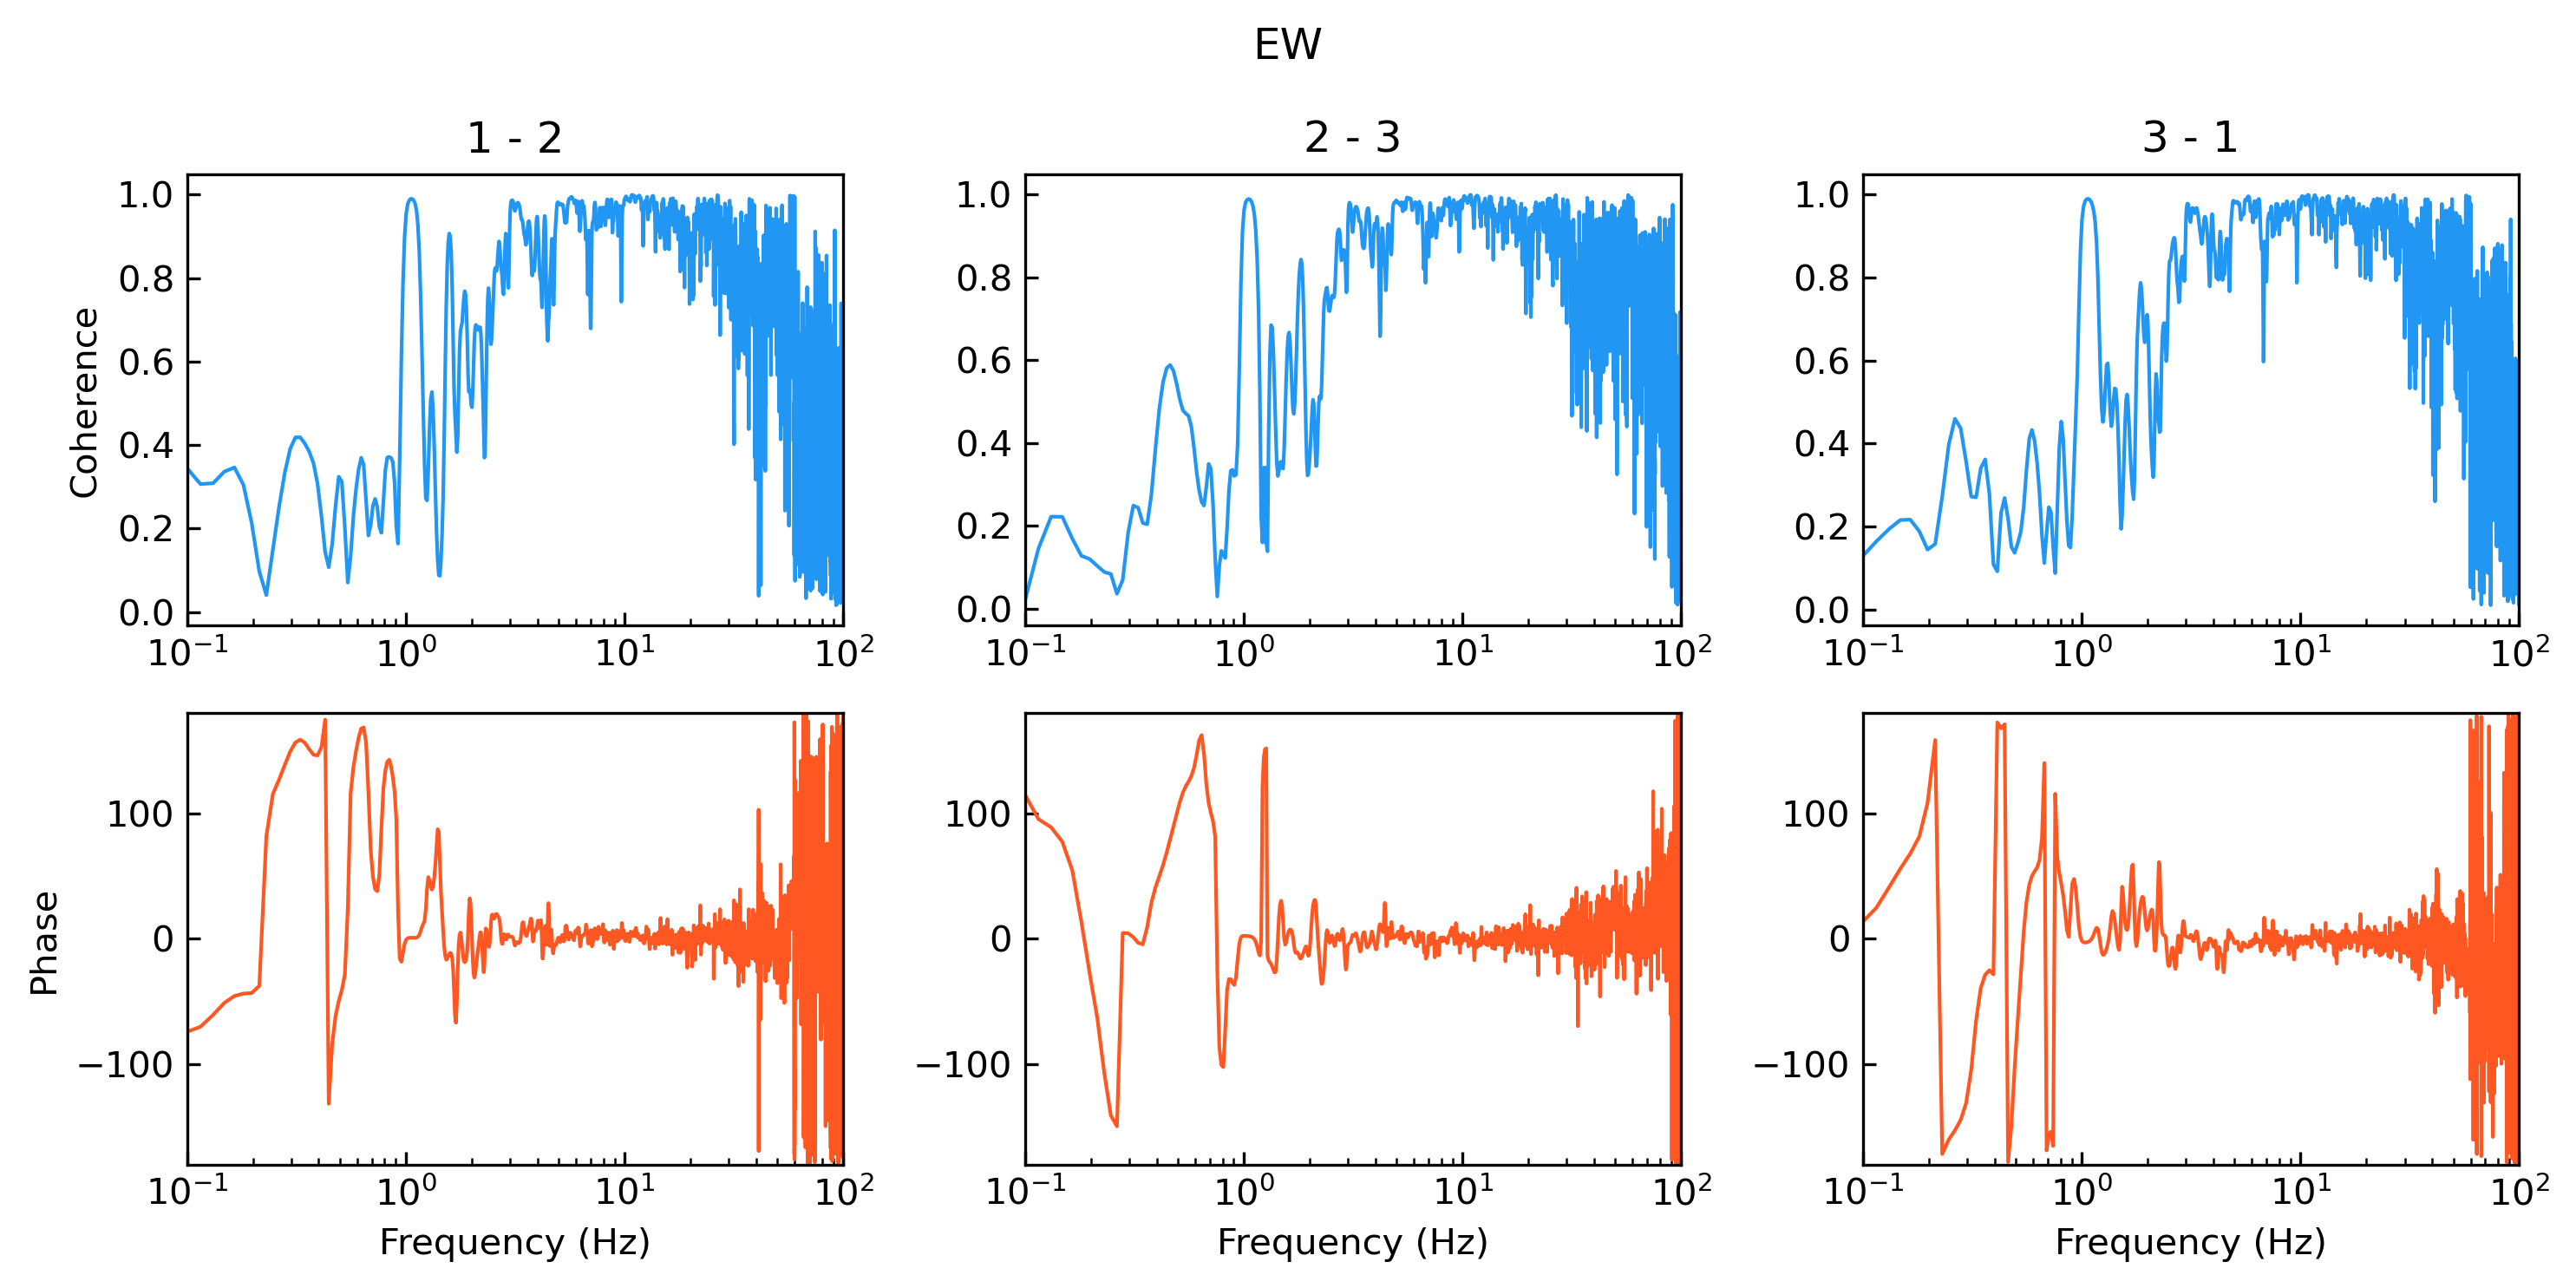

In [25]:
# ew components
ch = 'f102'
wave1 = st1.select(channel=ch)[0].data
wave2 = st2.select(channel=ch)[0].data
wave3 = st3.select(channel=ch)[0].data
plot_coherence(wave1, wave2, wave3, 'EW')


たぶん近くでジャンプしたり振動を与えた方がもっときれいに出るかも。